In [1]:
from rosemary import jpt_parse_args, jpt_setup, jpt_in_notebook; jpt_setup()

if jpt_in_notebook():
    import os
    print(os.environ['CUDA_VISIBLE_DEVICES'])
    os.environ['CUDA_VISIBLE_DEVICES'] = \
        os.environ['CUDA_VISIBLE_DEVICES'].split(',')[1]
    # '0,1,2,3,4,5'
    print(os.environ['CUDA_VISIBLE_DEVICES'])
    
!nvidia-smi

/gpfs/u/scratch/PTFM/PTFMqngp/github/rosemary/src/rosemary/__init__.py:25: UserWarning: Install `torch` for functionalities dependent on torch
  warn(f'Install `torch` for functionalities dependent on torch')


4,5
5
Wed Jan  3 21:48:27 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000004:04:00.0 Off |                    0 |
| N/A   31C    P0    65W / 300W |  28181MiB / 32510MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000004:05:00.0 Off |                    0 |
| 

In [86]:
import os
import itertools
from rosemary import jpt_in_notebook
from llm.submit import submit_job, multiline_to_singleline, shell_scripts_template_slurm
from note_pruning import get_final_model_name
num_gpus = 1
job_duration = 6
log_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/'

test_run = 0
test_run = bool(test_run)

sort_by_list = []


# ### relies on `model_name`

# # model_name = 'llama-7b'; md = 'llama7b'
# # model_name = 'llama-7b+lora:r=256:a=256'; md = 'llama7b'
# # model_name = 'llama-7b+lora:r=256:a=4096+proj=4096'; md = 'llama7br256p4096'
# model_name = 'llama-7b+lora:r=512:a=11585+proj=4096'; md = 'llama7br512p4096'

# # model_name = 'llama2-7b+lora:r=256:a=256'; md = 'llama2:7b'
# # model_name = 'llama-7b+lima+lora:r=256:a=256'; md = 'llama7b'
# # model_name = 'mistral-7b+lora:r=256:a=256'; md = 'mistral7b'
# # model_name = 'all-mpnet-base-v2'; md = 'mpnet'
# # model_name = 'bge-large-en-v1.5'; md = 'bge'
# # model_name = 'codellama-7b+lora:r=256:a=256'; md = 'codellama7b'

# sort_by_list += [
#     'random_s=0', 'random_s=1', 'random_s=2',
# #     'log_prob', 'logit_margin', 'el2n_agg=mean', 'grad_loraB_l2n',
# #     'numtoks', 'ifd_and_log_pmi', 
# ]
# ###

##### does not rely on `model_name`.
model_name = ''
# md = 'llama7b'
# md = 'llama7br256p4096'
md = 'llama7br512p4096'
# md = 'pythia1br512p4096'

# subset_size = 50_000
# subset_size = 40_000
# subset_size = 20_000
# subset_size = 20_000
# subset_size = 10_000
# subset_size = 5_000
# subset_size = 3_000
# subset_size = 1_000
# subset_size = 500

# sort_by_list += [
#     f'dedup_md={md}_emb=text+embedding',
#     f'dppmap_k=vmf_gamma=auto{subset_size}_kmd=mpnet',
#     f'dppmap_k=rbf_gamma=auto{subset_size}_kmd={md}_kemb=text+embedding',
#     f'dppmap_k=vmf_gamma=auto{subset_size}_kmd={md}_kemb=grad+rp+loraB',
#     f'dppmap_k=vmf_gamma=auto{subset_size}_kmd=bge',
#     f'dppmap_k=vmf_gamma=auto{subset_size}_kmd={md}_kemb=text+embedding',
#     f'dppmap_k=rbf_gamma=auto{subset_size}_kmd={md}_kemb=grad+rp+loraB',
# ]
# sort_by_list += [
#     f'dppmap_k=vmf_gamma=1_kmd={md}_kemb=grad+rp+loraB',
#     f'dppmap_k=rbf_gamma=1_kmd={md}_kemb=text+embedding',
# ]
sort_by_list += [
#     f'dppmap_k=vmf_gamma=1_kmd={md}_kemb=grad+rp+loraB',
#     f'dppmap_k=rbf_gamma=1_kmd={md}_kemb=text+embedding',
    f'dppmap_k=vmf_gamma=1_kmd={md}_kemb=grad+rp+loraB_ord=random:s@0',
    f'dppmap_k=rbf_gamma=1_kmd={md}_kemb=text+embedding_ord=random:s@0',
]
#####


dataset_list = [
    ## newer with max_seq_len<=2048 exactly
#     'stanford_alpaca', 
    'sharegptv2',
#     'wizardlm',
#     'wizardlmv2',
#     'tulu_v2',
#     'open_orca_slim',
#     'oasst1',
#     'flan_v2',
#     'dolly',
#     'ultrachat200kv2',
    ## older
#     'lima',
#     'flan2022_1m',
#     'tulu_v1_mix',
#     'ultrachat',
    ## coding
#     'starcoder_commentinstr', 
#     'starcoder_commentinstr_cleaned',
#     'starcoder_commentinstrv2',
#     'starcoder_commentinstrv2_flppl',
#     'starcoder_commentinstrv5',
]


from note_pruning_analysis import data_inds_dir

options_list = itertools.product(dataset_list, sort_by_list)

print('test_run =',test_run)
cmds = []
for dataset, sort_by in options_list:
    model_name_ = get_final_model_name(model_name, sort_by)
    save_dir = os.path.join(data_inds_dir, model_name_, dataset)
    cmd = f"""
     python note_pruning.py \
        --dataset {dataset} \
        --sort_by {sort_by} \
        --model_name {model_name_} \
        --save_dir {save_dir} \
    """.strip()
    cmd = multiline_to_singleline(cmd)
    shell_scripts = shell_scripts_template_slurm.format(
        conda_env='open-instruct',
        cwd=os.getcwd(),
        cmd=cmd,
        log_dir=log_dir,
        save_dir=save_dir)
    out = submit_job(
        shell_scripts, 
        job_name=f'prune.{dataset}.{sort_by}', 
        nodes=1,
        num_cpus=64, # 32
        cpu_mem=400, # 128, total mem=700.
        num_gpus=num_gpus,
        gpu_type='v100',
        test_run=test_run,
        job_duration=job_duration,
    )
    cmds.append(cmd)
    print(cmd)
        
print('#cmds: ', len(cmds))


test_run = False

Submiting job with:
{
    "job_name": "prune.sharegptv2.dppmap_k=vmf_gamma=1_kmd=llama7br512p4096_kemb=grad+rp+loraB_ord=random:s@0",
    "nodes": 1,
    "num_cpus": 64,
    "cpu_mem": 400,
    "num_gpus": 1,
    "gpu_type": "v100",
    "test_run": false,
    "queue": "el8",
    "num_jobs": 1
}
python note_pruning.py --dataset sharegptv2 --sort_by dppmap_k=vmf_gamma=1_kmd=llama7br512p4096_kemb=grad+rp+loraB_ord=random:s@0 --model_name llama-7b+lora:r=512:a=11585+proj=4096 --save_dir /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/llama-7b+lora:r=512:a=11585+proj=4096/sharegptv2

Submiting job with:
{
    "job_name": "prune.sharegptv2.dppmap_k=rbf_gamma=1_kmd=llama7br512p4096_kemb=text+embedding_ord=random:s@0",
    "nodes": 1,
    "num_cpus": 64,
    "cpu_mem": 400,
    "num_gpus": 1,
    "gpu_type": "v100",
    "test_run": false,
    "queue": "el8",
    "num_jobs": 1
}
python note_pruning.py --dataset sharegptv2 --sort_by

In [83]:
with open('note_pruning_run_cmds.sh', 'w') as f:
    s = 'set -e\nset -x\n'
    devices = os.environ['CUDA_VISIBLE_DEVICES'].split(',')[-1]
    s += '\n\n'.join([f"CUDA_VISIBLE_DEVICES={devices} "+x for x in cmds])
    f.write(s)

In [84]:
!bash note_pruning_run_cmds.sh

+ CUDA_VISIBLE_DEVICES=5
+ python note_pruning.py --dataset oasst1 --sort_by random_s=0 --model_name llama-7b+lora:r=512:a=11585+proj=4096 --save_dir /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/llama-7b+lora:r=512:a=11585+proj=4096/oasst1
/gpfs/u/scratch/PTFM/PTFMqngp/github/rosemary/src/rosemary/__init__.py:25: UserWarning: Install `torch` for functionalities dependent on torch
  warn(f'Install `torch` for functionalities dependent on torch')
{
  "dataset": "oasst1",
  "sort_by": "random_s=0",
  "model_name": "llama-7b+lora:r=512:a=11585+proj=4096",
  "save_dir": "/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/llama-7b+lora:r=512:a=11585+proj=4096/oasst1"
}
Rank datapoints with random_s=0 took 0.68 seconds.
save inds (length = 33717) to /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/llama-7b+lora:r=512:a=11585+proj=4096/oasst1/random_s=0_incr.

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=512:a=11585+proj=4096/oasst1/random_s=1_neg/sorted_partition=10:10.txt completed!
Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=512:a=11585+proj=4096/oasst1/random_s=1_neg/sorted1000_beg.txt completed!
Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=512:a=11585+proj=4096/oasst1/random_s=1_neg/sorted1000_end.txt completed!
Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=512:a=11585+proj=4096/oasst1/random_s=1_neg/sorted1000_random.txt completed!
Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=512:a=11585+proj=4096/oasst1/random_s=1_neg/sorted10000_beg.txt completed!
Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=512:a=11585+proj=4096/oasst1/random_s=1_neg/sorted10000_end.txt completed!
Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=512:a=11585+proj=4096/oasst1/random_s=1_neg/sorted10000_random.txt completed!
+ CUDA_VISIBLE_DEVICES=5
+ python note_prunin

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=512:a=11585+proj=4096/flan_v2/random_s=0/sorted10000_end.txt completed!
Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=512:a=11585+proj=4096/flan_v2/random_s=0/sorted10000_random.txt completed!
Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/flan_v2/json/default-613130a990f0e4e1/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)
Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=512:a=11585+proj=4096/flan_v2/random_s=0_neg/sorted_beg.txt completed!
Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=512:a=11585+proj=4096/flan_v2/random_s=0_neg/sorted_end.txt completed!
Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=512:a=11585+proj=4096/flan_v2/random_s=0_neg/sorted_random.txt completed!
Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=512:a=11585+proj=4096/flan_v2/random_s=0_neg/sort

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=512:a=11585+proj=4096/flan_v2/random_s=2/sorted_end.txt completed!
Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=512:a=11585+proj=4096/flan_v2/random_s=2/sorted_random.txt completed!
Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=512:a=11585+proj=4096/flan_v2/random_s=2/sorted_partition=1:10.txt completed!
Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=512:a=11585+proj=4096/flan_v2/random_s=2/sorted_partition=10:10.txt completed!
Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=512:a=11585+proj=4096/flan_v2/random_s=2/sorted1000_beg.txt completed!
Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=512:a=11585+proj=4096/flan_v2/random_s=2/sorted1000_end.txt completed!
Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=512:a=11585+proj=4096/flan_v2/random_s=2/sorted1000_random.txt completed!
Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=512:a=1158

Rank datapoints with random_s=1 took 0.12 seconds.
save inds (length = 14956) to /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/llama-7b+lora:r=512:a=11585+proj=4096/dolly/random_s=1_incr.pkl
save inds (length = 14956) to /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/llama-7b+lora:r=512:a=11585+proj=4096/dolly/random_s=1_decr.pkl
Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/dolly/json/default-f1edb4674ed9b465/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)
Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=512:a=11585+proj=4096/dolly/random_s=1/sorted_beg.txt completed!
Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=512:a=11585+proj=4096/dolly/random_s=1/sorted_end.txt completed!
Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=512:a=11585+proj=4096/dolly/random_s=

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=512:a=11585+proj=4096/dolly/random_s=2_neg/sorted10000_random.txt completed!
+ CUDA_VISIBLE_DEVICES=5
+ python note_pruning.py --dataset ultrachat200kv2 --sort_by random_s=0 --model_name llama-7b+lora:r=512:a=11585+proj=4096 --save_dir /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/llama-7b+lora:r=512:a=11585+proj=4096/ultrachat200kv2
/gpfs/u/scratch/PTFM/PTFMqngp/github/rosemary/src/rosemary/__init__.py:25: UserWarning: Install `torch` for functionalities dependent on torch
  warn(f'Install `torch` for functionalities dependent on torch')
{
  "dataset": "ultrachat200kv2",
  "sort_by": "random_s=0",
  "model_name": "llama-7b+lora:r=512:a=11585+proj=4096",
  "save_dir": "/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/llama-7b+lora:r=512:a=11585+proj=4096/ultrachat200kv2"
}
Rank datapoints with random_s=0 took 2.30 seconds.
save inds (l

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=512:a=11585+proj=4096/ultrachat200kv2/random_s=1_neg/sorted_beg.txt completed!
Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=512:a=11585+proj=4096/ultrachat200kv2/random_s=1_neg/sorted_end.txt completed!
Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=512:a=11585+proj=4096/ultrachat200kv2/random_s=1_neg/sorted_random.txt completed!
Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=512:a=11585+proj=4096/ultrachat200kv2/random_s=1_neg/sorted_partition=1:10.txt completed!
Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=512:a=11585+proj=4096/ultrachat200kv2/random_s=1_neg/sorted_partition=10:10.txt completed!
Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=512:a=11585+proj=4096/ultrachat200kv2/random_s=1_neg/sorted1000_beg.txt completed!
Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=512:a=11585+proj=4096/ultrachat200kv2/random_s=1_neg/sorted1000_end.txt comp

### Generate curriculum from pre-computed scores (via `note_pruning.py`)

In [28]:
import itertools
from note_curriculum import (
    get_curriculum_scores,
    get_curriculum,
    generate_curriculum,
    generate_curriculum_forall_scoring_fn,
    scores_path_to_attrs,
    np_random_choice_maximize_noreplacement,
    plt_curriculum,
)
from note_pruning_analysis import assets_dir

# model_name = 'llama-7b'; dataset = 'tulu_v1_mix'; M = 150_000; num_epochs = 3
# model_name = 'llama-7b'; dataset = 'sharegpt'; M = 150_000; num_epochs = 3

## mistral+ultrachat
# model_name = 'mistral-7b'; dataset = 'ultrachat200k'; M = 50_000; num_epochs = 2
# model_name = 'mistral-7b'; dataset = 'ultrachat15'; M = 100_000; num_epochs = 2
# model_name = 'mistral-7b'; dataset = 'ultrachat15'; M = 200_000; num_epochs = 2

## semdedup
# model_name = 'bge-large-en-v1.5'; dataset = 'wizardlm'; M = 100_000; num_epochs = 2
# model_name = 'all-mpnet-base-v2'; dataset = 'ultrachat15'; M = 100_000; num_epochs = 2
# model_name = 'all-mpnet-base-v2'; dataset = 'tulu_v1_mix'; M = 150_000; num_epochs = 2
# model_name = 'mistral-7b'; dataset = 'ultrachat15'; M = 100_000; num_epochs = 2

## starcoder
# M = 25_000; num_epochs=5; model_name = ['codellama-7b', 'all-mpnet-base-v2']; \
#     dataset = ['starcoder_commentinstr_cleaned', 'starcoder_commentinstr']
# M = 50_000; num_epochs=5; model_name = ['codellama-7b', 'all-mpnet-base-v2']; \
#     dataset = ['starcoder_commentinstrv2']

## wizardlm
# model_name = ['llama-7b', 'all-mpnet-base-v2', 'bge-large-en-v1.5']; dataset = ['wizardlm']
# M = 100_000; num_epochs = 2
# M = 50_000; num_epochs = 5
# M = 10_000; num_epochs = 10

## tulu_v1_mix
# model_name = ['llama-7b', 'all-mpnet-base-v2', 'bge-large-en-v1.5']; dataset = ['tulu_v1_mix']
# M = 50_000; num_epochs = 5
# M = 150_000; num_epochs = 3

## tulu_v2, open_orca_slim, sharegptv2
model_name = ['llama-7b', 'llama2-7b', 'all-mpnet-base-v2', 'bge-large-en-v1.5', 'codellama-7b', 'pythia-1b']
# dataset = ['tulu_v2']
# dataset = ['open_orca_slim']
# dataset = ['sharegptv2']
# dataset = ['stanford_alpaca']
dataset = ['flan_v2']
# dataset = ['oasst1']
# dataset = ['wizardlmv2']
# dataset = ['ultrachat200kv2']
# dataset = ['dolly']
# dataset = ['stanford_alpaca', 'oasst1', 'wizardlm']
# dataset = ['starcoder_commentinstrv5']

# M = 60_000; num_epochs = 3 # ->20k
# M = 50_000; num_epochs = 5 # ->10k
M = 10_000; num_epochs = 10 # ->1k



pacing_fn_list = [
#     f'prune_size={M}_ep=1',
    f'prune_size={M}_ep={num_epochs}',
#     f'prune_size={M}_ep=3',
#     f'singlestep_size={M}_startingfrac=0.1',
#     f'singlestep_size={M}_startingfrac=0.05',
#     f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=1.5',
]

output_list = generate_curriculum_forall_scoring_fn(
    model_name, dataset, pacing_fn_list, verbose=False)

save inds (length = 10000) to curriculum/llama-7b+lora:r=512:a=11585+proj=4096/flan_v2/dppmap_k=vmf_gamma=auto1000_kmd=llama7br512p4096_kemb=grad+rp+loraB/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=256:a=256/flan_v2/numtoks_input/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=256:a=256/flan_v2/numtoks_total_neg/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=256:a=256/flan_v2/numtoks_input_neg/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=256:a=256/flan_v2/el2n_agg=mean_neg/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=256:a=256/flan_v2/logit_margin_neg/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=256:a=256/flan_v2/random_s=0_neg/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=256:a=256/flan

In [ ]:
import re
import numpy as np
from note_curriculum import get_curriculum_scores, generate_curriculum, plt_curriculum
import glob
import matplotlib.pyplot as plt

model_name = 'mistral-7b'; dataset = 'ultrachat'; M =  50_000
# model_name = 'llama-7b'; dataset = 'tulu_v1_mix'; M = 150_000


paths = glob.glob('curriculum/*/*/*/scores.pkl')
paths = [x for x in paths if 'llama' in x and 'tulu_v1_mix' in x and 'log_prob_neg' in x]
path = paths[0]

verbose = True
print(path)
pacing_fn = f'prune_size={M}_ep=3'
# pacing_fn = f'singlestep_size={M}_startingfrac=0.1'
# pacing_fn = f'singlestep_size={M}_startingfrac=0.2'
# pacing_fn = f'singlestep_size={M}_startingfrac=0.3'
# pacing_fn = f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=2'
# pacing_fn = f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=1.5'
# pacing_fn = f'fep_size={M}_nsteps=5_startingfrac=0.2_inc=1.5'
# pacing_fn = f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=1.5'

pacing_fn_list = [
    f'prune_size={M}_ep=3',
    f'singlestep_size={M}_startingfrac=0.05',
#     f'singlestep_size={M}_startingfrac=0.1',
#     f'singlestep_size={M}_startingfrac=0.2',
#     f'singlestep_size={M}_startingfrac=0.3',
#     f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=1.5',
#     f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=2',
#     f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=3',
    f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=1.5',
    f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=2',
#     f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=3',
#     f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=1.25'
]



nrows = len(pacing_fn_list)
fig, axs = plt.subplots(nrows, 3, figsize=(15,3*nrows), sharey=False, gridspec_kw={'width_ratios': [2,.5,.5]})

for i, pacing_fn in enumerate(pacing_fn_list):

    plt_kwargs = generate_curriculum(path, pacing_fn, verbose=True, save_output=False)
    output = plt_kwargs.pop('output')
    plt_kwargs.update({'fig': fig, 'axs': axs[i]})
    plt_curriculum(**plt_kwargs)

fig.tight_layout()



save_plt = 0
if save_plt:
    model_name, dataset, scoring_fn = output['model_name'], output['dataset'], output['scoring_fn']
    save_path = os.path.join(
        assets_dir, f'note_curriculum_{model_name}:{dataset}:{scoring_fn}.png')
    fig.savefig(save_path, bbox_inches='tight', dpi=100)



curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/log_prob_neg/scores.pkl
fixed exponential pacing startingfrac=0.05, inc=20.0, nsteps=2 
Implies: step_lens=[25000, 25000], stepwise_data_fracs=[0.05, 1.0]
fixed exponential pacing startingfrac=0.05, inc=1.5, nsteps=5 
Implies: step_lens=[10000, 10000, 10000, 10000, 10000], stepwise_data_fracs=[0.05, 0.07500000000000001, 0.1125, 0.16875, 0.253125]
fixed exponential pacing startingfrac=0.05, inc=2.0, nsteps=5 
Implies: step_lens=[10000, 10000, 10000, 10000, 10000], stepwise_data_fracs=[0.05, 0.1, 0.2, 0.4, 0.8]
Error in callback <function flush_figures at 0x7fff5ba411b0> (for post_execute):


### main code

In [2]:
import os
import sys
import numpy as np
import time
import re
import random
import json
import pickle
from tqdm import tqdm 

import pyarrow
import torch
import transformers
import pandas as pd

from note_pruning import (
    save_to_pickle,
    save_sorted_inds,
    sort_kmeans_dist_to_cluster_centers,
    save_prune_results,
)
from note_pruning_analysis import get_lm_output
from note_pruning_dpp import torch_vmf_kernel, torch_rbf_kernel
from functools import partial

from transformers import AutoTokenizer

from rosemary import parse_kv_from_string, create_string_from_kv
from note_pruning_analysis import lm_output_dir, get_dataset_token_lengths, get_full_model_name, md_to_model_name

import note_pruning_dpp
import note_pruning_clustering

In [3]:
test_run = False
dataset = 'tulu_v1_human_mix'
dataset = 'tulu_v2_human_mix'
dataset = 'flan_v2'
dataset = 'lima'
dataset = 'dolly'
# dataset = 'flan2022_1m'
# dataset = 'lima'
# dataset = 'ultrachat200k'
# dataset = 'tulu_v1_mix'
# dataset = 'wizardlm'
# dataset = 'ultrachat15'
# dataset = 'starcoder_commentinstr_cleaned'

sort_by = 'random_s=0'

# used for generating model output.
model_name = 'llama-7b'
# model_name = 'llama-7b_ft=hmv1'
# model_name = 'llama-7b+lora:r=256:a=256'
# model_name = 'llama-7b+lima+lora:r=256:a=256'
# model_name = 'mistral-7b+lora:r=256:a=256'
# model_name = 'all-mpnet-base-v2'
# model_name = 'bge-large-en-v1.5'
# model_name = 'codellama-7b+lora:r=256:a=256'


# save_dir = f"data_inds/"
# from note_pruning import get_final_model_name
# model_name_ = get_final_model_name(model_name, sort_by)
# save_dir = os.path.join(save_dir, model_name_, dataset)
# os.makedirs(save_dir, exist_ok=True) 

# print(dataset, model_name, sort_by)
# print(save_dir)

In [73]:
from note_pruning_dpp import get_dppmap_run_info
import re
import numpy as np
from rosemary import parse_kv_from_string, create_string_from_kv
from note_curriculum import get_curriculum_scores
from note_pruning_analysis import curriculum_dir
from note_pruning import get_dppmap_autotune_gamma_search_result
import note_pruning_dpp
import json
from note_pruning import parse_sort_by_and_compute_dppmap

kmd = 'llama7b'


dataset = 'stanford_alpaca'
gamma = 2e-4
# sort_by = f'dppmap_k=vmf_gamma=auto1000_kmd={kmd}_kemb=grad+rp+loraB_ord=random:s@0'
# sort_by = f'dppmap_k=vmf_gamma={gamma}_kmd={kmd}_kemb=grad+rp+loraB_ord=random:s@0'
sort_by = f'dppmap_k=vmf_gamma={gamma}_kmd={kmd}_kemb=grad+rp+loraB_ord=random:s@1'
# sort_by = f'dppmap_k=vmf_gamma={gamma}_kmd={kmd}_kemb=grad+rp+loraB'
# sort_by = f'dppmap_k=lin_gamma=1_kmd={kmd}_kemb=grad+rp+loraB'
# sort_by = f'dppmap_k=lin_gamma=10_kmd={kmd}_kemb=grad+rp+loraB'

# dataset = 'sharegptv2'
# sort_by = f'dppmap_k=vmf_gamma=auto1000_kmd={kmd}_kemb=grad+rp+loraB_ord=random:s@1'


parse_sort_by_and_compute_dppmap(sort_by, dataset)

Calling note_pruning_dpp.compute_dppmap with kwargs={
    "dppmap_type": "dppmap",
    "dataset": "stanford_alpaca",
    "kernel_type": "vmf",
    "kernel_embed_model": "llama7b",
    "kernel_embed_type": "grad_rp_loraB",
    "kernel_kwargs": {
        "gamma": 0.0002
    },
    "quality_score_type": null,
    "quality_score_embed_model": null,
    "theta": 0.0,
    "device": "cuda",
    "max_length": 55000,
    "prespecified_ordering": "random_s=1",
    "run_name": "dppmap_k=vmf_gamma=0.0002_kmd=llama7b_kemb=grad+rp+loraB_ord=random:s@1"
}


KeyboardInterrupt: 

In [54]:

def get_dppmap_marginal_gains(sort_by, dataset):
    import pickle
    from note_pruning_analysis import scripts_dir
    save_path = os.path.join(scripts_dir, 'dpp', dataset, sort_by, 'data.pkl')
    with open(save_path, 'rb') as f:
        data = pickle.load(f)
    di2s = np.array(data['marginal_gains'])
    marginal_gains = np.log(di2s) + np.log(1e10)
    return marginal_gains

sort_by = 'dppmap_k=vmf_gamma=6.83e-05_kmd=llama7b_kemb=grad+rp+loraB_ord=random:s@1'
sort_by = f'dppmap_k=lin_gamma=10_kmd={kmd}_kemb=grad+rp+loraB'
di2s = get_dppmap_marginal_gains(sort_by, dataset)
    


ValueError: 'greedy' is not a valid format string (two color symbols)

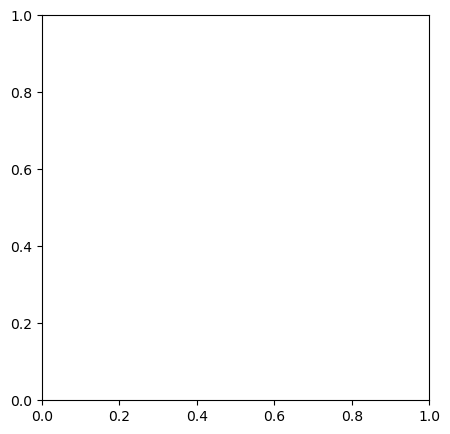

In [48]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(5,5))

marginal_gains = np.log(di2s)
marginal_gains = marginal_gains + np.log(1e10)
ax.plot(marginal_gains, 'greedy')
ax.set_ylabel('marginal_gains')
# ax.set_yscale('log')
ax.legend()
ax.set_xlabel('Iterations')

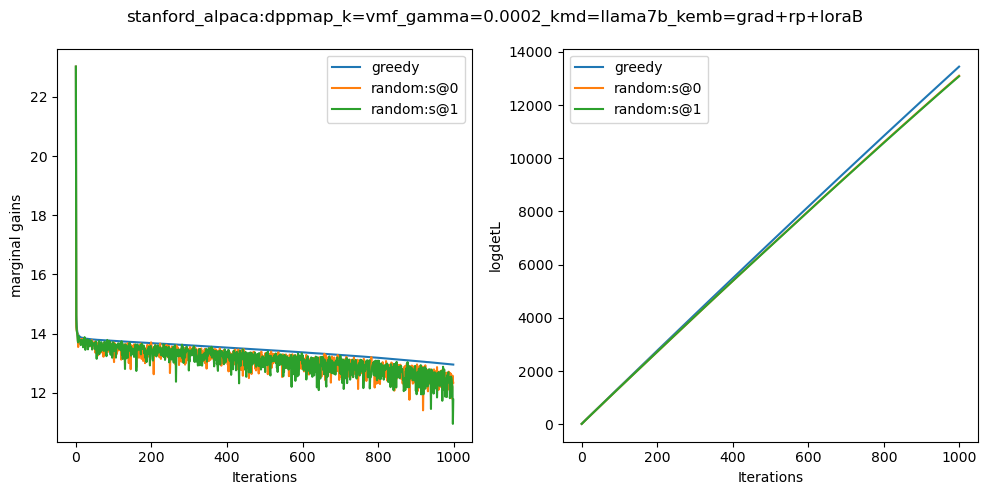

In [72]:
import matplotlib.pyplot as plt
import pickle

dataset = 'stanford_alpaca'
# sort_by = 'dppmap_k=vmf_gamma=3.43e-05_kmd=llama7br256p4096_kemb=grad+rp+loraB'
# sort_by = 'dppmap_k=vmf_gamma=6.83e-05_kmd=llama7b_kemb=grad+rp+loraB'
sort_by = 'dppmap_k=vmf_gamma=0.0002_kmd=llama7b_kemb=grad+rp+loraB'

# dataset = 'sharegptv2'
# sort_by = 'dppmap_k=vmf_gamma=5.7e-05_kmd=llama7b_kemb=grad+rp+loraB'

label_to_sort_by = {
    'greedy': sort_by,
    'random:s@0': sort_by+'_ord=random:s@0',
    'random:s@1': sort_by+'_ord=random:s@1',
}

M = 1000
mgs = {
    k: get_dppmap_marginal_gains(v, dataset)[:M] for k, v in label_to_sort_by.items()
}


fig, axs = plt.subplots(1,2,figsize=(10,5))

ax = axs[0]
for k, mg in mgs.items():
    ax.plot(mg, label=k)
ax.set_ylabel('marginal gains')
# ax.set_yscale('log')
ax.legend()
ax.set_xlabel('Iterations')

ax = axs[1]
for k, mg in mgs.items():
    ax.plot(np.cumsum(mg), label=k)
ax.set_ylabel('logdetL')
# ax.set_yscale('log')
ax.legend()
ax.set_xlabel('Iterations')
# ax.set_title(f'logdet(L_greedy)/logdet(L_rand) = '
#              f'{mg_cumsum[-1]/mg_rand_cumsum[-1]:0f} ')

fig.suptitle(f'{dataset}:{sort_by}')
fig.tight_layout()

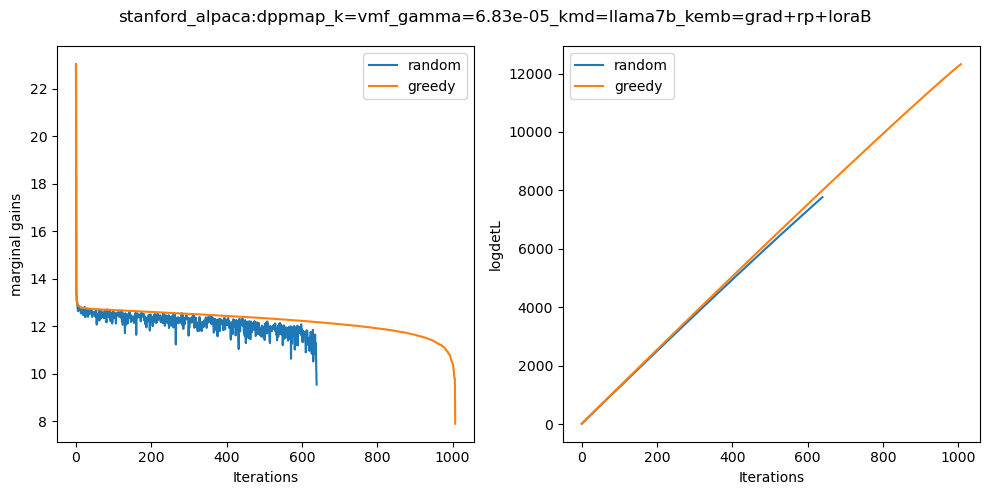

In [56]:
import matplotlib.pyplot as plt
import pickle

dataset = 'stanford_alpaca'
# sort_by = 'dppmap_k=vmf_gamma=3.43e-05_kmd=llama7br256p4096_kemb=grad+rp+loraB'
sort_by = 'dppmap_k=vmf_gamma=6.83e-05_kmd=llama7b_kemb=grad+rp+loraB'

dataset = 'sharegptv2'
sort_by = 'dppmap_k=vmf_gamma=5.7e-05_kmd=llama7b_kemb=grad+rp+loraB'

mg_rand = get_dppmap_marginal_gains(sort_by+'_ord=random:s@1', dataset)
mg = get_dppmap_marginal_gains(sort_by, dataset)



fig, axs = plt.subplots(1,2,figsize=(10,5))

ax = axs[0]
ax.plot(mg_rand, label='random')
ax.plot(mg, label='greedy')
ax.set_ylabel('marginal gains')
# ax.set_yscale('log')
ax.legend()
ax.set_xlabel('Iterations')

ax = axs[1]
ax.plot(np.cumsum(mg_rand), label='random')
ax.plot(np.cumsum(mg), label='greedy')
ax.set_ylabel('logdetL')
# ax.set_yscale('log')
ax.legend()
ax.set_xlabel('Iterations')

fig.suptitle(f'{dataset}:{sort_by}')
fig.tight_layout()

In [1]:
import pickle
dataset = 'stanford_alpaca'
sort_by = 'dppmap_k=vmf_gamma=3.43e-05_kmd=llama7br256p4096_kemb=grad+rp+loraB'

# dataset = 'sharegptv2'
# sort_by = 'dppmap_k=vmf_gamma=5.7e-05_kmd=llama7b_kemb=grad+rp+loraB'

p = (f'/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/dpp/{dataset}/'
     f'{sort_by}_ord=random:s@1/data.pkl')
with open(p, 'rb') as f:
    o = pickle.load(f)
mg_rand = o['marginal_gains'][1:]

p = (f'/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/dpp/{dataset}/'
     f'{sort_by}/data.pkl')
with open(p, 'rb') as f:
    o = pickle.load(f)
mg = o['marginal_gains'][1:]

fig, axs = plt.subplots(1,2,figsize=(10,5))

ax = axs[0]
ax.plot(mg_rand, label='random')
ax.plot(mg, label='greedy')
ax.set_ylabel('di2')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('Iterations')

ax = axs[1]
ax.plot(np.cumsum(mg_rand), label='random')
ax.plot(np.cumsum(mg), label='greedy')
ax.set_ylabel('cumulative di2')
# ax.set_yscale('log')
ax.legend()
ax.set_xlabel('Iterations')

NameError: name 'plt' is not defined

In [77]:
kvs = parse_kv_from_string(sort_by)

if kvs['k'] == 'vmf':
    kernel_kwargs = {'gamma': kvs['gamma']}
elif kvs['k'] == 'rbf':
    kernel_kwargs = {'gamma': kvs['gamma']}
elif kvs['k'] == 'lin':
    kernel_kwargs = {'gamma': kvs.get('gamma', 1.)}
else:
    kernel_kwargs = {}

if dataset != 'ultrachat15':
    max_length = 55_000
else:
    max_length = 20_000
    
prespecified_ordering = re.sub(':', '_', re.sub('@', '=', kvs['ord'])) if 'ord' in kvs else None
if prespecified_ordering:
    ## just run for target_size
    assert('auto' in kvs['gamma'])
    match = re.search(r'auto([\d.e+-]+)', sort_by)
    max_length = int(match.group(1))
    ## fetch prev run autotune-ed gamma, and use it for this run
    kvs_ = {k: v for k, v in kvs.items() if k not in [0, 'ord']}
    sort_by_without_ord = kvs[0]+'_'+create_string_from_kv(kvs_)
    d = get_dppmap_autotune_gamma_search_result(sort_by_without_ord, dataset)
    kernel_kwargs = {'gamma': d['gamma']}
    sort_by = re.sub(r'auto\d+', str(d['gamma']), sort_by)


kwargs = {
    'dppmap_type': 'dppmap',
    'dataset': dataset,
    'kernel_type': kvs['k'],
    'kernel_embed_model': kvs['kmd'],
    'kernel_embed_type': re.sub(r'[+]', '_', kvs['kemb']) if 'kemb' in kvs else 'text_embedding',
    'kernel_kwargs': kernel_kwargs,
    'quality_score_type': re.sub(r'[+]', '_', kvs['q']) if 'q' in kvs else None,
    'quality_score_embed_model': kvs.get('qmd', None),
    'theta': kvs.get('theta', 0.), # defaults to just diversity no quality
    'device': 'cuda',
    'max_length': max_length, # balance finish job within 6 hrs with wanting to prune a lot. meaning resulting scores will only be valid up to 20k for large datasets.
    'prespecified_ordering': prespecified_ordering,
    'run_name': sort_by,
}
print(f'Calling note_pruning_dpp.compute_dppmap with kwargs={json.dumps(kwargs, indent=4)}')

# note_pruning_dpp.compute_dppmap(**kwargs)

[autotune gamma result] Found gamma=3.43e-05 / M=1003 is within 0.01 of target_size=1000
Calling note_pruning_dpp.compute_dppmap with kwargs={
    "dppmap_type": "dppmap",
    "dataset": "stanford_alpaca",
    "kernel_type": "vmf",
    "kernel_embed_model": "llama7br256p4096",
    "kernel_embed_type": "grad_rp_loraB",
    "kernel_kwargs": {
        "gamma": 3.43e-05
    },
    "quality_score_type": null,
    "quality_score_embed_model": null,
    "theta": 0.0,
    "device": "cuda",
    "max_length": 1000,
    "prespecified_ordering": "random_s=1",
    "run_name": "dppmap_k=vmf_gamma=3.43e-05_kmd=llama7br256p4096_kemb=grad+rp+loraB_ord=random:s@1"
}


'dppmap_k=vmf_gamma=0.0238_kmd=llama7br256p4096_kemb=grad+rp+loraB_ord=random:s@1'

In [44]:

kvs = parse_kv_from_string(sort_by)
kvs.pop('ord')

kvs = parse_kv_from_string(sort_by)


